In [95]:
import sys
import os.path as path
import os
HERE_PATH = os.getcwd()
os.chdir(os.path.dirname(HERE_PATH))
from utils.loftr_utils import load_LoFTR, rgb2loftrgray, crop_image, mask2loftr
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import cv2

In [96]:
def modfied_black(image):
    # 将图片转换为 NumPy 数组
    image_array = np.array(image)

    # 获取图像的高度和宽度
    height, width = image_array.shape[:2]

    # 将右侧 1/2 和上面 1/2 的像素设置为黑色
    # 右侧 1/2
    image_array[:, width // 2:] = 0
    # 上面 1/2
    image_array[:height // 2, :] = 0

    # 将 NumPy 数组转换回 PIL 图像
    return Image.fromarray(image_array)

torch.Size([1, 1, 480, 640])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[160.,  48.],
        [128., 128.],
        [136., 136.],
        [272., 176.],
        [280., 176.],
        [264., 200.],
        [120., 248.]], device='cuda:0')


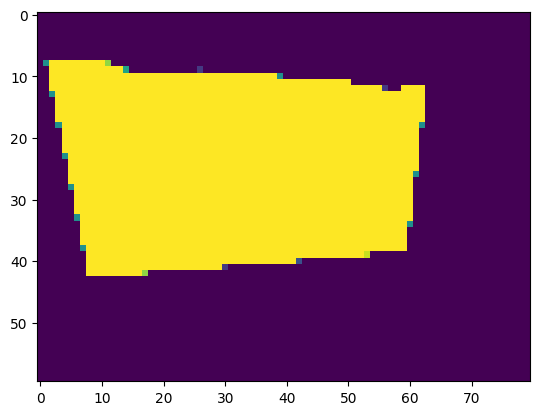

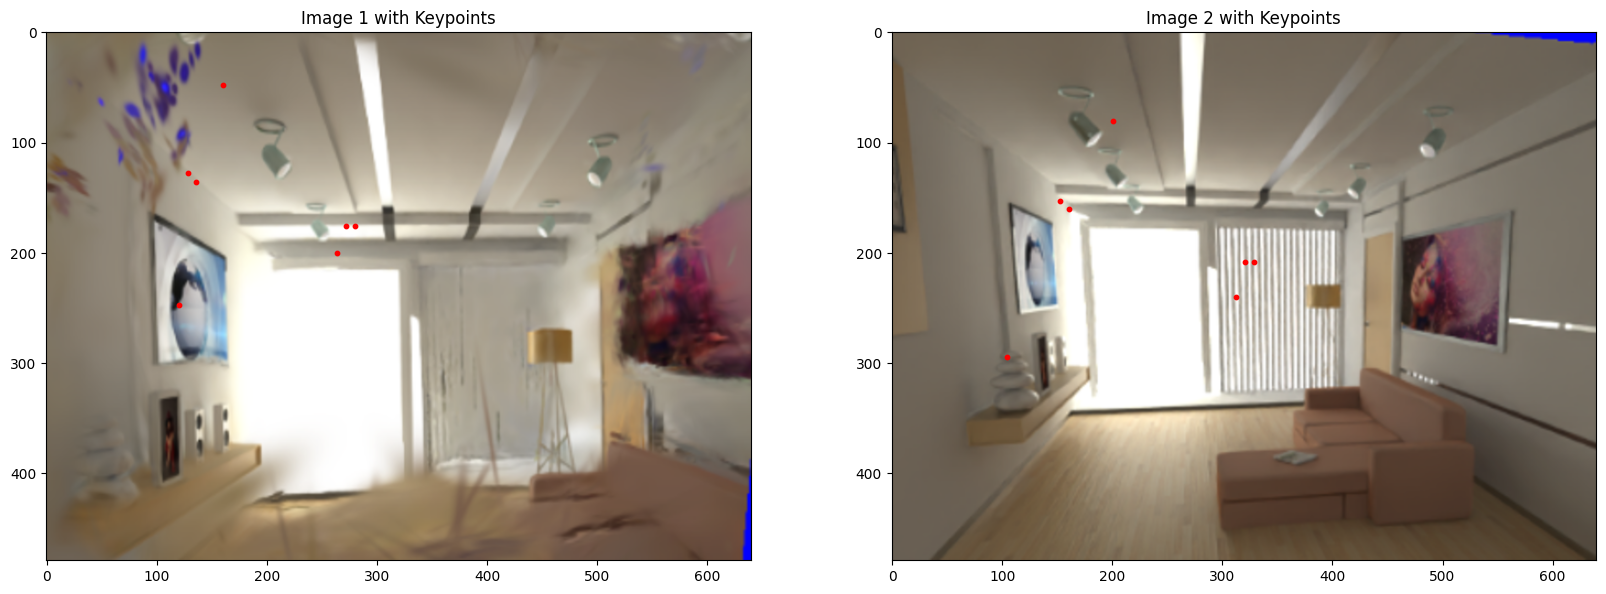

In [97]:
LOFTR_CKPT = '/hdd/gaussian-splatting/LoFTR/ckpt/indoor_ds_new.ckpt'
LoFTR_temp_bug_fix = False
Confidence_threshold_LoFTR = 0.2
Min_matching_points = 5
LoFTR_model=load_LoFTR(LOFTR_CKPT,LoFTR_temp_bug_fix)
to_tensor = transforms.ToTensor()

r1 = Image.open("/hdd/gaussian-splatting/vis/1.png")
r2 = Image.open("/hdd/gaussian-splatting/vis/2.png")
mask = cv2.imread("/hdd/Data/MirrorGS/office/masks/MirrorMask_0157.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
mask = torch.tensor(mask)>127


mask2 = cv2.imread("/hdd/Data/MirrorGS/office/masks/MirrorMask_0157.png")
mask2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)
_, mask2 = cv2.threshold(mask2, 128, 255, cv2.THRESH_BINARY)
# mask to tensor
mask2 = torch.tensor(mask2)>127
# mask2 = torch.tensor(mask2)>0.1

# r1 = modfied_black(r1)
# r2 = modfied_black(r2)
r1 = to_tensor(r1).permute(1, 2, 0)
r2 = to_tensor(r2).permute(1, 2, 0)

r1 = r1[:,:,:3]
r2 = r2[:,:,:3]
# r1[~mask] = torch.tensor([0,0,1.0])
# r2[~mask2] = torch.tensor([0,0,1.0])
r1 = r1.permute(2, 0, 1)
r2 = r2.permute(2, 0, 1)
q_img_gray=rgb2loftrgray(r2)
r_img_gray = rgb2loftrgray(r1)

q_mask = mask2loftr(mask2)
r_mask = mask2loftr(mask)
print(q_img_gray.shape)
print(q_mask)
# plot qmask
plt.imshow(q_mask.squeeze(0).cpu().numpy())
batch = {'image0':q_img_gray, 'image1':r_img_gray}
LoFTR_model(batch)
mkpts0 = batch['mkpts0_f']
mkpts1 = batch['mkpts1_f']
mconf = batch['mconf']

indices = torch.nonzero(mconf > Confidence_threshold_LoFTR).squeeze()
import matplotlib.pyplot as plt

# Filter the matching points based on the high confidence indices
mkpts0_high_conf = mkpts0[indices]
mkpts1_high_conf = mkpts1[indices]
print(mkpts0_high_conf)


# Convert tensors to numpy arrays for plotting
mkpts0_np = mkpts0_high_conf.detach().cpu().numpy()
mkpts1_np = mkpts1_high_conf.detach().cpu().numpy()

# Convert images back to PIL format for plotting
r1_img = transforms.ToPILImage()(r1.cpu())
r2_img = transforms.ToPILImage()(r2.cpu())

# Create a figure to display the images and matching points
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Display the images
ax[0].imshow(r1_img)
ax[0].scatter(mkpts0_np[:, 0]*r1_img.width/640, mkpts0_np[:, 1]*r1_img.height/480, c='r', s=10)
ax[0].set_title('Image 1 with Keypoints')

ax[1].imshow(r2_img)
ax[1].scatter(mkpts1_np[:, 0]*r1_img.width/640, mkpts1_np[:, 1]*r1_img.height/480, c='r', s=10)
ax[1].set_title('Image 2 with Keypoints')

# Draw lines between matching points
# for i in range(len(mkpts0_np)):
#     con = plt.Line2D([mkpts0_np[:, 0]*r1_img.width/640, mkpts1_np[:, 0]*r1_img.width/640], 
#                      [mkpts0_np[:, 1]*r1_img.height/480, mkpts1_np[:, 1]*r1_img.height/480], 
#                      color='yellow', linewidth=1)
#     fig.add_artist(con)

plt.show()



tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])
torch.Size([1440, 1920])


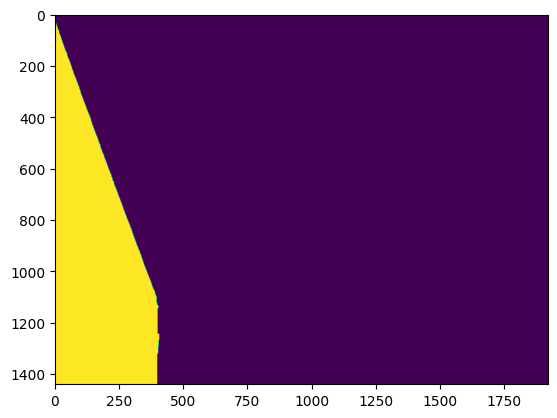

In [98]:
image = Image.open("/hdd/Data/MirrorGS/discussion_room/discussion_room/images/frame_01100.jpg")

img = to_tensor(image).permute(1, 2, 0)
mask = cv2.imread("/hdd/mirror-gs/dataset/market/masks/frame_00038.jpg")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
# mask to tensor
mask = torch.tensor(mask)>127
plt.imshow(mask)
print(mask)
print(mask.shape)
#crop = crop_image(img, mask)
# visualize crop
# plt.imshow(crop)
